# Crime Pattern Analysis based on ML & Apache Spark

In [0]:
# Spark imports
#from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import *

# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Model preparation and ML models imports
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
content_cols = '''
ID - Unique identifier for the record.
Case Number - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
Date - Date when the incident occurred. this is sometimes a best estimate.
Block - The partially redacted address where the incident occurred, placing it on the same block as the actual address.
IUCR - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.
Primary Type - The primary description of the IUCR code.
Description - The secondary description of the IUCR code, a subcategory of the primary description.
Location Description - Description of the location where the incident occurred.
Arrest - Indicates whether an arrest was made.
Domestic - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
Beat - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
District - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.
Ward - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
Community Area - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.
FBI Code - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.
X Coordinate - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Y Coordinate - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Year - Year the incident occurred.
Updated On - Date and time the record was last updated.
Latitude - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Longitude - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Location - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.'''

In [0]:
# Turn a list of headers to a list of dictionaries
def entry_dic(line):
  #Convert a header - description line into a single dictionary that holds the original header as 'title', a corresponding field name as 'header', and a description.
  pair = line.split(' - ')
  return {'title': pair[0], 'description': pair[1], 'header': pair[0].lower().replace(' ', '_')}
  
l=list()
for j in (content_cols.split('\n')):
  if j!='':
    l.append(j)
header_dics = list(map(entry_dic, l))
header_dics[:2]

Out[3]: [{'title': 'ID',
 'description': 'Unique identifier for the record.',
 'header': 'id'},
 {'title': 'Case Number',
 'description': 'The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.',
 'header': 'case_number'}]

In [0]:
df = spark.read.csv('dbfs:/FileStore/tables/*.csv', inferSchema=True, header=True)
# Caching this data frame as it's going to be read over and over again
df = df.cache()

In [0]:
for h in header_dics:
    df = df.withColumnRenamed(h['title'], h['header'])
df = df.rdd.filter(lambda rec: rec.arrest.find('Location Description') < 0).toDF().cache()

## Crime Analysis

In [0]:
crime_type_groups = df.groupBy('primary_type').count()
crime_type_counts = crime_type_groups.orderBy('count', ascending=False)
print("Total crime count:",df.count())

Total crime count: 7145216

In [0]:
df.printSchema()

root
-- _c0: long (nullable = true)
-- id: long (nullable = true)
-- case_number: string (nullable = true)
-- date: string (nullable = true)
-- block: string (nullable = true)
-- iucr: string (nullable = true)
-- primary_type: string (nullable = true)
-- description: string (nullable = true)
-- location_description: string (nullable = true)
-- arrest: string (nullable = true)
-- domestic: string (nullable = true)
-- beat: string (nullable = true)
-- district: string (nullable = true)
-- ward: string (nullable = true)
-- community_area: string (nullable = true)
-- fbi_code: string (nullable = true)
-- x_coordinate: string (nullable = true)
-- y_coordinate: string (nullable = true)
-- year: string (nullable = true)
-- updated_on: string (nullable = true)
-- latitude: string (nullable = true)
-- longitude: string (nullable = true)
-- location: string (nullable = true)
-- date_time: timestamp (nullable = true)
-- month: date (nullable = true)

In [0]:
crime_type_counts.show(truncate=False)

+--------------------------------+-------+
primary_type |count |
+--------------------------------+-------+
THEFT |1476357|
BATTERY |1298240|
CRIMINAL DAMAGE |835284 |
NARCOTICS |796053 |
OTHER OFFENSE |440882 |
ASSAULT |432898 |
BURGLARY |430571 |
MOTOR VEHICLE THEFT |328764 |
ROBBERY |271450 |
DECEPTIVE PRACTICE |247713 |
CRIMINAL TRESPASS |207722 |
PROSTITUTION |76768 |
WEAPONS VIOLATION |70352 |
PUBLIC PEACE VIOLATION |54362 |
OFFENSE INVOLVING CHILDREN |45568 |
CRIM SEXUAL ASSAULT |25690 |
SEX OFFENSE |24301 |
GAMBLING |17455 |
LIQUOR LAW VIOLATION |15115 |
INTERFERENCE WITH PUBLIC OFFICER|14993 |
+--------------------------------+-------+
only showing top 20 rows

In [0]:
counts_pddf = pd.DataFrame(crime_type_counts.rdd.map(lambda l: l.asDict()).collect())
counts_pddf.head(10)

Out[21]:

,primary_type,count
0,THEFT,1476357
1,BATTERY,1298240
2,CRIMINAL DAMAGE,835284
3,NARCOTICS,796053
4,OTHER OFFENSE,440882
5,ASSAULT,432898
6,BURGLARY,430571
7,MOTOR VEHICLE THEFT,328764
8,ROBBERY,271450
9,DECEPTIVE PRACTICE,247713


Out[22]:

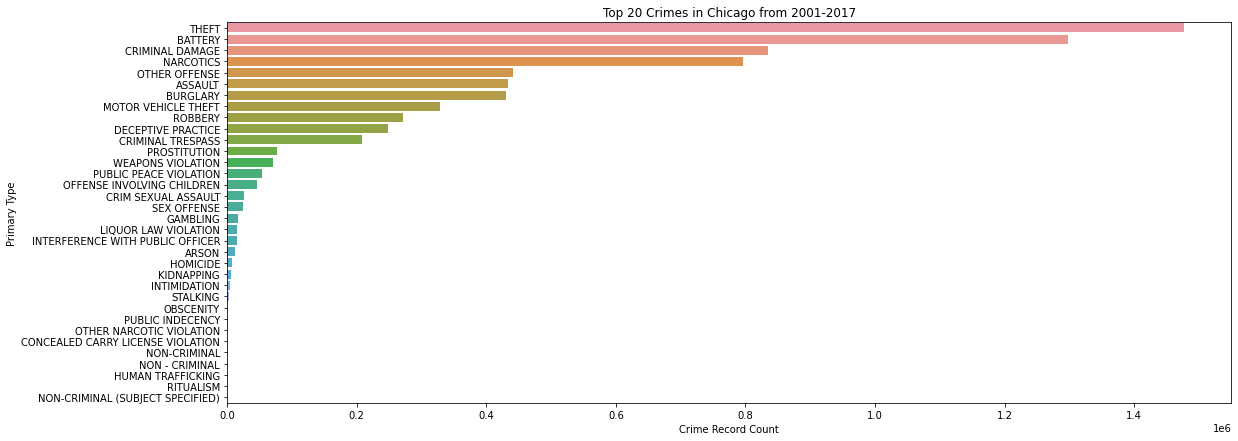

[Text(0, 0.5, 'Primary Type'), Text(0.5, 0, 'Crime Record Count')]

In [0]:
plt.rcParams["figure.figsize"] = [18, 7]
sns.set_color_codes("pastel")

types = sns.barplot(x='count', y='primary_type', data=counts_pddf)
types.set_title('Top 20 Crimes in Chicago from 2001-2017')
types.set(ylabel="Primary Type", xlabel="Crime Record Count")

In [0]:
df.select(min('date').alias('first_record_date'), max('date').alias('latest_record_date')).show(truncate=False)

+----------------------+----------------------+
first_record_date |latest_record_date |
+----------------------+----------------------+
01/01/2001 01:00:00 AM|12/31/2016 12:56:00 AM|
+----------------------+----------------------+

In [0]:
#Add month column
df = df.withColumn('date_time', to_timestamp('date', 'MM/dd/yyyy hh:mm:ss a')).withColumn('month', trunc('date_time', 'YYYY'))
df.select(['date','date_time', 'month']).show(n=2, truncate=False)

+----------------------+-------------------+----------+
date |date_time |month |
+----------------------+-------------------+----------+
03/01/2003 12:00:00 AM|2003-03-01 00:00:00|2003-01-01|
05/01/2003 01:00:00 AM|2003-05-01 01:00:00|2003-01-01|
+----------------------+-------------------+----------+
only showing top 2 rows

In [0]:
# Crime types and arrest over years:

type_arrest_date = df.groupBy(['arrest', 'month']).count().orderBy(['month', 'count'], ascending=[True, False])

# A pandas data frame of the collected dictionary version of the date-grouped DF above
type_arrest_pddf = pd.DataFrame(type_arrest_date.rdd.map(lambda l: l.asDict()).collect())
type_arrest_pddf['yearpd'] = type_arrest_pddf['month'].apply(lambda dt: datetime.datetime.strftime(pd.Timestamp(dt), '%Y'))

In [0]:
type_arrest_pddf['arrest'] = type_arrest_pddf['arrest'].apply(lambda l: l=='True')
type_arrest_pddf.head(10)

Out[26]:

,arrest,month,count,yearpd
0,False,2001-01-01,3661,2001
1,True,2001-01-01,1034,2001
2,False,2002-01-01,248784,2002
3,True,2002-01-01,96185,2002
4,False,2003-01-01,330854,2003
5,True,2003-01-01,140284,2003
6,False,2004-01-01,268741,2004
7,True,2004-01-01,116098,2004
8,False,2005-01-01,310289,2005
9,True,2005-01-01,140281,2005


Out[27]:

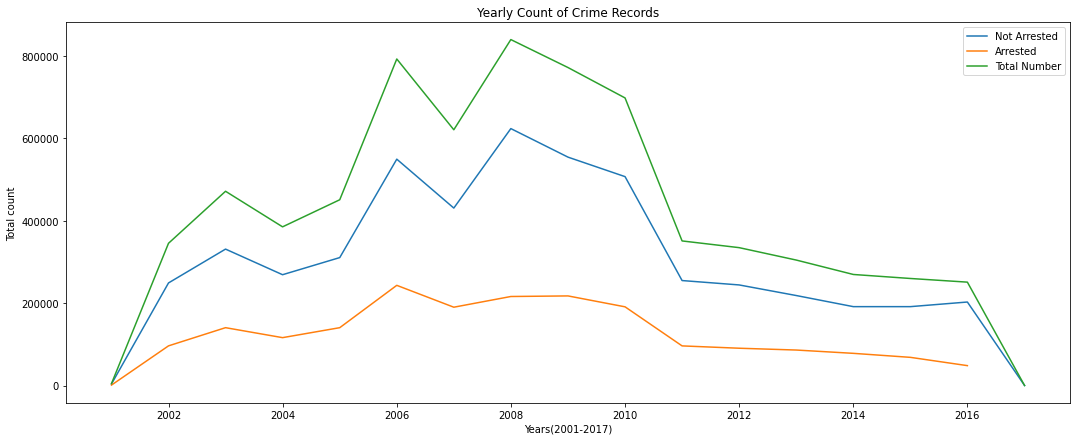

<matplotlib.legend.Legend at 0x7ff68b749a30>

In [0]:
# How arrest and non-arrest crimes have changed over the years
# Data for plotting
total=pd.merge(type_arrest_pddf['month'], type_arrest_pddf['count'], right_index = True,left_index = True)
total_cnt = total.groupby(total['month']).aggregate({'month':'first','count':'sum'})
arrested = type_arrest_pddf[type_arrest_pddf['arrest'] == True]
not_arrested = type_arrest_pddf[type_arrest_pddf['arrest'] == False]

fig, ax = plt.subplots()
plt.figure(figsize=(16, 6))
ax.plot(not_arrested['month'], not_arrested['count'], label='Not Arrested')
ax.plot(arrested['month'], arrested['count'], label='Arrested')
ax.plot(total_cnt['month'], total_cnt['count'], label='Total Number')
ax.set(xlabel='Years(2001-2017)', ylabel='Total count',title='Yearly Count of Crime Records')
ax.legend()

In [0]:
#Analyze criminal activity on hourly basis
# Extract the "hour" field from the date into a separate column called "hour"
df = df.withColumn('hour', hour(df['date_time']))

# Derive a data frame with crime count per hour of the day:
hourly_count = df.groupBy(['primary_type', 'hour']).count().cache()
hourly_total_count = hourly_count.groupBy('hour').sum('count')
hourly_count_pddf = pd.DataFrame(hourly_total_count.select(hourly_total_count['hour'], hourly_total_count['sum(count)'].alias('count'))\
                                .rdd.map(lambda l: l.asDict())\
                                 .collect())
hourly_count_pddf = hourly_count_pddf.sort_values(by='hour')

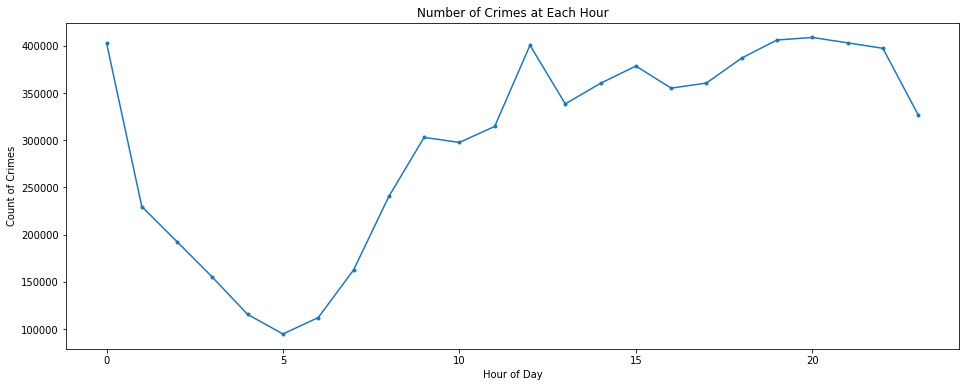

In [0]:
# Plot of crime activity over hours of day
plt.figure(figsize=(16, 6))
plt.plot(hourly_count_pddf['hour'], hourly_count_pddf['count'],marker='.')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Crimes')
plt.title('Number of Crimes at Each Hour')
plt.show()

In [0]:
# Number of types of location recorded in the dataset
print(df.select('location_description').distinct().count())
df.groupBy(['location_description']).count().orderBy('count', ascending=False).show(5)

170
+--------------------+-------+
location_description| count|
+--------------------+-------+
 STREET|1868059|
 RESIDENCE|1179074|
 SIDEWALK| 767843|
 APARTMENT| 759648|
 OTHER| 257795|
+--------------------+-------+
only showing top 5 rows

In [0]:
#Crimes on street or at residence
street_home_hour = df.where((df['location_description'] == 'STREET') | (df['location_description'] == 'RESIDENCE'))
street_home_hour=(street_home_hour.groupBy(['location_description','hour']).count().orderBy('count', ascending=False))
street_home_hour.show(5)

+--------------------+----+------+
location_description|hour| count|
+--------------------+----+------+
 STREET| 22|140552|
 STREET| 21|132046|
 STREET| 20|125963|
 STREET| 0|125341|
 STREET| 19|113337|
+--------------------+----+------+
only showing top 5 rows

Out[32]:

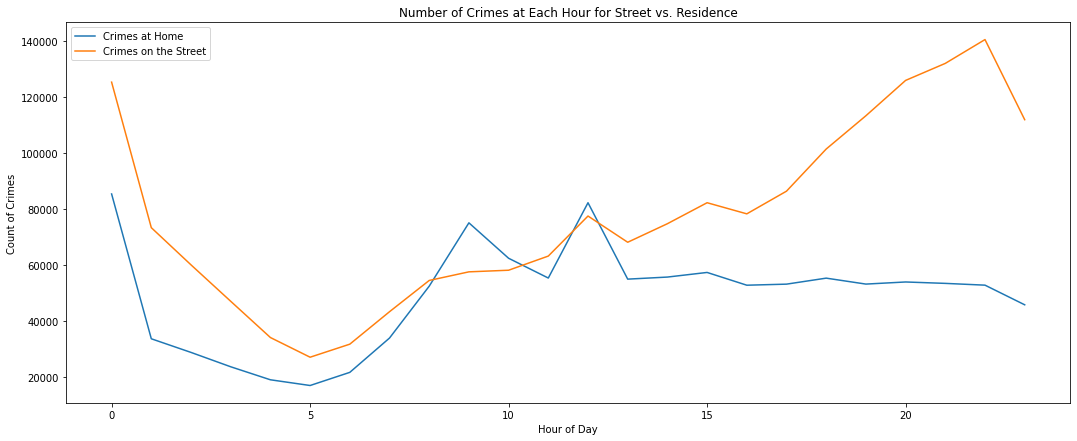

<matplotlib.legend.Legend at 0x7ff68b6bd430>

In [0]:
#Plot crimes that occur at home and on streets over hours of a day
street_home_hour_pddf = pd.DataFrame(street_home_hour.rdd.map(lambda row: row.asDict()).collect())
street_home_hour_pddf = street_home_hour_pddf.sort_values(by='hour')

figure, axes = plt.subplots()
plt.title('Number of Crimes at Each Hour for Street vs. Residence')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Crimes')
axes.plot(street_home_hour_pddf[street_home_hour_pddf['location_description'] == 'RESIDENCE']['hour'], 
          street_home_hour_pddf[street_home_hour_pddf['location_description'] == 'RESIDENCE']['count'],
         label='Crimes at Home')

axes.plot(street_home_hour_pddf[street_home_hour_pddf['location_description'] == 'STREET']['hour'], 
          street_home_hour_pddf[street_home_hour_pddf['location_description'] == 'STREET']['count'],
         label='Crimes on the Street')

axes.legend()

In [0]:
#New dataframe with additional time columns
df_dates = df.withColumn('week_day', dayofweek(df['date_time']))\
                 .withColumn('year_month', month(df['date_time']))\
                 .withColumn('month_day', dayofmonth(df['date_time']))\
                 .withColumn('date_number', datediff(df['date_time'], to_date(lit('2001-01-01'), format='yyyy-MM-dd')))\
                 .cache()

Out[34]:

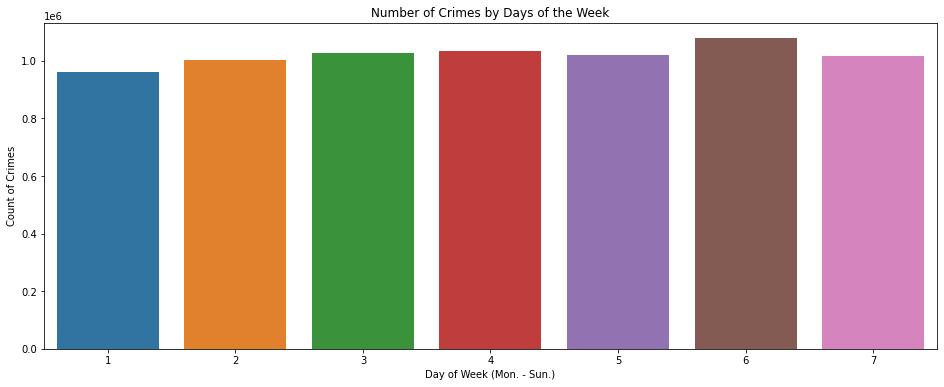

Text(0.5, 0, 'Day of Week (Mon. - Sun.)')

In [0]:
#Plot crimes over weekdays
week_day_crime_counts = df_dates.groupBy('week_day').count()
week_day_crime_counts_pddf = pd.DataFrame(week_day_crime_counts.orderBy('week_day').rdd.map(lambda e: e.asDict()).collect())

plt.figure(figsize=(16, 6))
ax=sns.barplot(data=week_day_crime_counts_pddf, x='week_day', y='count')
ax.set_title('Number of Crimes by Days of the Week')
ax.set_ylabel('Count of Crimes')
ax.set_xlabel('Day of Week (Mon. - Sun.)')

Out[35]:

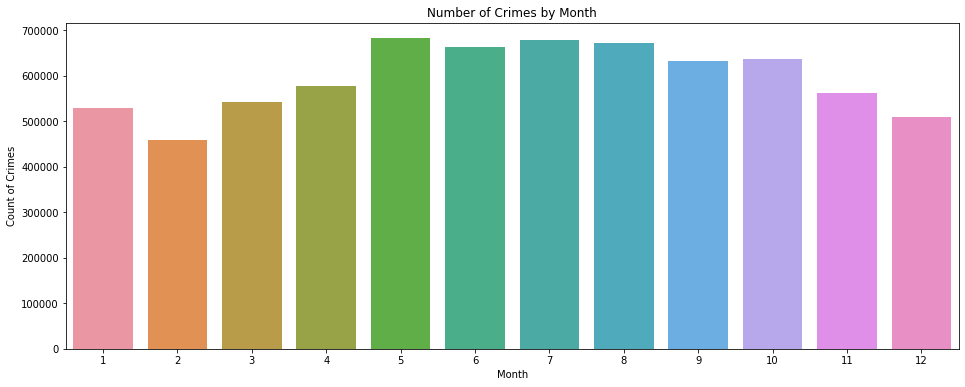

Text(0.5, 0, 'Month')

In [0]:
# Plot crimes over months
year_month_crime_counts = df_dates.groupBy('year_month').count()
year_month_crime_counts_pddf = pd.DataFrame(year_month_crime_counts.orderBy('year_month').rdd.map(lambda e: e.asDict()).collect())

plt.figure(figsize=(16, 6))
ax = sns.barplot(data=year_month_crime_counts_pddf, y='count', x='year_month')
ax.set_title('Number of Crimes by Month')
ax.set_ylabel('Count of Crimes')
ax.set_xlabel('Month')

No handles with labels found to put in legend.
Out[36]:

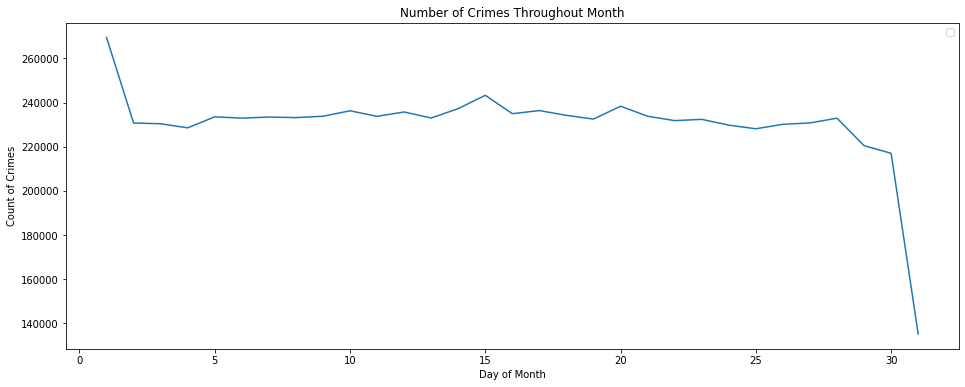

<matplotlib.legend.Legend at 0x7ff68c2f86d0>

In [0]:
#Plot crimes over days of month
month_day_crime_counts = df_dates.groupBy('month_day').count()
month_day_crime_counts_pddf = pd.DataFrame(month_day_crime_counts.orderBy('month_day').rdd.map(lambda e: e.asDict()).collect())

month_day_crime_counts_pddf = month_day_crime_counts_pddf.sort_values(by='month_day', ascending=True)
plt.figure(figsize=(16, 6))
plt.plot(month_day_crime_counts_pddf['month_day'],month_day_crime_counts_pddf['count'])
plt.title('Number of Crimes Throughout Month')
plt.ylabel('Count of Crimes')
plt.xlabel('Day of Month')
plt.legend()

In [0]:
#Top 10 areas with highest crime
df_dates_community_areas = df_dates.na.drop(subset=['community_area']).groupBy('community_area').count()
df_dates_community_areas.orderBy('count', ascending=False).show(10)

+--------------+------+
community_area| count|
+--------------+------+
 25.0|461420|
 43.0|234706|
 8.0|232033|
 23.0|225846|
 67.0|214275|
 24.0|211000|
 71.0|204611|
 28.0|203009|
 29.0|199354|
 68.0|195120|
+--------------+------+
only showing top 10 rows

In [0]:
## Is it possible to see how the top crime types occur in the top crime-affected areas?
top_crime_types = df_dates.select('primary_type').groupBy('primary_type').count().rdd.map(lambda row: row.asDict()).takeOrdered(5, key=lambda l: 1/l['count'])
top_busy_areas =  df_dates_community_areas.rdd.map(lambda row: row.asDict()).takeOrdered(5, key=lambda l: 1/l['count'])

top_crime_types_lst = [dc['primary_type'] for dc in top_crime_types]
top_busy_areas_lst = [dc['community_area'] for dc in top_busy_areas]

In [0]:
# Dataframe filtered by these top community areas and top crime types:
q1 = "instr('" + ' '.join(top_busy_areas_lst) + "', community_area) > 0"
q2 = "instr('" + ' '.join(top_crime_types_lst) + "', primary_type) > 0"

df_dates_tops = df_dates.filter(q1).filter(q2)

In [0]:
tops_of_tops = df_dates_tops.groupBy(['primary_type', 'community_area']).count().orderBy(['primary_type', 'count', 'community_area'], ascending=[True, False, True]).cache()

In [0]:
#Community area names to better understand locations
area_names = """
01	Rogers Park	
40	Washington Park
02	West Ridge	
41	Hyde Park
03	Uptown	
42	Woodlawn
04	Lincoln Square	
43	South Shore
05	North Center	
44	Chatham
06	Lakeview	
45	Avalon Park
07	Lincoln Park	
46	South Chicago
08	Near North Side	
47	Burnside
09	Edison Park	
48	Calumet Heights
10	Norwood Park	
49	Roseland
11	Jefferson Park	
50	Pullman
12	Forest Glen	
51	South Deering
13	North Park	
52	East Side
14	Albany Park	
53	West Pullman
15	Portage Park	
54	Riverdale
16	Irving Park	
55	Hegewisch
17	Dunning	
56	Garfield Ridge
18	Montclare	
57	Archer Heights
19	Belmont Cragin	
58	Brighton Park
20	Hermosa	
59	McKinley Park
21	Avondale	
60	Bridgeport
22	Logan Square	
61	New City
23	Humboldt Park	
62	West Elsdon
24	West Town	
63	Gage Park
25	Austin	
64	Clearing
26	West Garfield Park 	
65	West Lawn
27	East Garfield Park	
66	Chicago Lawn
28	Near West Side	
67	West Englewood
29	North Lawndale	
68	Englewood
30	South Lawndale	
69	Greater Grand Crossing
31	Lower West Side	
70	Ashburn
32	Loop	
71	Auburn Gresham	
33	Near South Side	
72	Beverly
34	Armour Square	
73	Washington Heights
35	Douglas	
74	Mount Greenwood
36	Oakland	
75	Morgan Park
37	Fuller Park	
76	O'Hare
38	Grand Boulevard	
77	Edgewater
39	Kenwood	
"""

In [0]:
code_pairs = [[float(p[0]), p[1]] for p in [pair.strip().split('\t') for pair in area_names.strip().split('\n')]]

In [0]:
#Crime count by community area
community_area_counts = pd.DataFrame(df_dates_community_areas.rdd.map(lambda row: row.asDict()).collect())
#Area codes to names
area_name_dic = {float(k[0]):k[1] for k in code_pairs}
community_area_counts['community_area_name'] = community_area_counts['community_area'].apply(lambda area: area_name_dic.get(float(area),  'unknown_%s'%area))
community_area_counts = community_area_counts.sort_values(by='count')
community_area_counts.head(5)

Out[43]:

,community_area,count,community_area_name
22,0.0,87,unknown_0.0
24,9.0,6872,Edison Park
11,47.0,10840,Burnside
25,12.0,12771,Forest Glen
53,55.0,15355,Hegewisch


In [0]:
#Join community areas on main data frame
code_pairs_df = spark.createDataFrame(code_pairs, ['community_area', 'area_name'])
named_tops_of_tops = code_pairs_df.join(tops_of_tops, on='community_area', how='right')
named_tops_of_tops.show(10)

+--------------+---------------+---------------+-----+
community_area| area_name| primary_type|count|
+--------------+---------------+---------------+-----+
 25.0| Austin| BATTERY|90877|
 43.0| South Shore| BATTERY|50699|
 67.0| West Englewood| BATTERY|50476|
 23.0| Humboldt Park| BATTERY|45196|
 8.0|Near North Side| BATTERY|30683|
 3.0| Uptown| BATTERY|17514|
 7.0| Lincoln Park| BATTERY|10202|
 5.0| North Center| BATTERY| 4400|
 25.0| Austin|CRIMINAL DAMAGE|40386|
 43.0| South Shore|CRIMINAL DAMAGE|27512|
+--------------+---------------+---------------+-----+
only showing top 10 rows

Out[45]:

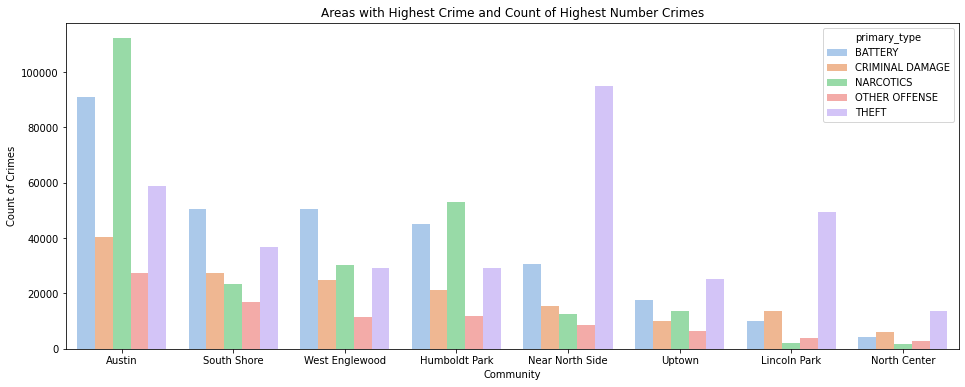

Text(0.5, 1.0, 'Areas with Highest Crime and Count of Highest Number Crimes')

In [0]:
tops_of_tops_dff = pd.DataFrame(named_tops_of_tops.rdd.map(lambda l: l.asDict()).collect() )
plt.figure(figsize=(16, 6))
ax=sns.barplot(data=tops_of_tops_dff, x='area_name', y='count', hue='primary_type', palette='pastel')
ax.set_ylabel('Count of Crimes')
ax.set_xlabel('Community')
ax.set_title("Areas with Highest Crime and Count of Highest Number Crimes")

In [0]:
#Features to be considered for models
selected_features = ['location_description', 'arrest', 'domestic', 'district', 'ward', 'community_area', 'fbi_code', 'hour','week_day','year_month', 'month_day']

In [0]:
features_df = df_dates.select(selected_features)
features_df.printSchema()

root
-- location_description: string (nullable = true)
-- arrest: string (nullable = true)
-- domestic: string (nullable = true)
-- district: string (nullable = true)
-- ward: string (nullable = true)
-- community_area: string (nullable = true)
-- fbi_code: string (nullable = true)
-- hour: integer (nullable = true)
-- week_day: integer (nullable = true)
-- year_month: integer (nullable = true)
-- month_day: integer (nullable = true)

In [0]:
feature_level_count_dic = []
for feature in selected_features:
    print('Analysing', feature)
    levels_list_df = features_df.select(feature).distinct()
    feature_level_count_dic.append({'feature': feature, 'level_count': levels_list_df.count()})

Analysing location_description
Analysing arrest
Analysing domestic
Analysing district
Analysing ward
Analysing community_area
Analysing fbi_code
Analysing hour
Analysing week_day
Analysing year_month
Analysing month_day

In [0]:
pd.DataFrame(feature_level_count_dic).sort_values(by='level_count', ascending=False)

Out[49]:

,feature,level_count
0,location_description,170
5,community_area,78
4,ward,50
10,month_day,31
3,district,26
6,fbi_code,26
7,hour,24
9,year_month,12
8,week_day,7
1,arrest,2


### Preparing for Models

In [0]:
df_dates_features = df_dates.na.drop(subset=selected_features)

#Use string indexer of spark to index selected features
for feature in feature_level_count_dic:
    indexer = StringIndexer(inputCol=feature['feature'], outputCol='%s_indexed' % feature['feature'])
    print('Fitting feature:',feature['feature'])
    model = indexer.fit(df_dates_features)
    print('Transforming:', feature['feature'])
    df_dates_features = model.transform(df_dates_features)

#String indexing of labels
response_indexer = StringIndexer(inputCol='primary_type', outputCol='primary_type_indexed')
response_model = response_indexer.fit(df_dates_features)
df_dates_features = response_model.transform(df_dates_features)    

Fitting feature: location_description
Transforming: location_description
Fitting feature: arrest
Transforming: arrest
Fitting feature: domestic
Transforming: domestic
Fitting feature: district
Transforming: district
Fitting feature: ward
Transforming: ward
Fitting feature: community_area
Transforming: community_area
Fitting feature: fbi_code
Transforming: fbi_code
Fitting feature: hour
Transforming: hour
Fitting feature: week_day
Transforming: week_day
Fitting feature: year_month
Transforming: year_month
Fitting feature: month_day
Transforming: month_day

In [0]:
#Vectorize features using vector assembler which vectorizes all predictors into features column
indexed_features = ['%s_indexed' % fc['feature'] for fc in feature_level_count_dic]
indexed_features

Out[51]: ['location_description_indexed',
 'arrest_indexed',
 'domestic_indexed',
 'district_indexed',
 'ward_indexed',
 'community_area_indexed',
 'fbi_code_indexed',
 'hour_indexed',
 'week_day_indexed',
 'year_month_indexed',
 'month_day_indexed']

In [0]:
assembler = VectorAssembler(inputCols=indexed_features, outputCol='features')
vectorized_df_dates = assembler.transform(df_dates_features)

#Split dataset into 80/20
train, test = vectorized_df_dates.randomSplit([0.8, 0.2])

## Multinomial Logistic Regression:

In [0]:
logisticRegression = LogisticRegression(labelCol='primary_type_indexed', featuresCol='features', maxIter=12, family='multinomial')
logModel = logisticRegression.fit(train)
model_summary = logModel.summary

In [0]:
mlrpredictions = logModel.transform(test)
mlrpredictions.select("description","primary_type","probability","primary_type_indexed","prediction").show(n = 50, truncate = 30)

+------------------------------+--------------------------+------------------------------+--------------------+----------+
 description| primary_type| probability|primary_type_indexed|prediction|
+------------------------------+--------------------------+------------------------------+--------------------+----------+
 HARASSMENT BY TELEPHONE| OTHER OFFENSE|[9.767629816078235E-5,0.228...| 4.0| 4.0|
 OTHER WEAPONS VIOLATION| OTHER OFFENSE|[0.021755020165554927,0.269...| 4.0| 1.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.7411000651799337,0.12367...| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.559933007910419,0.129082...| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.6641855706771387,0.11711...| 0.0| 0.0|
AGG SEX ASSLT OF CHILD FAM MBR|OFFENSE INVOLVING CHILDREN|[6.294308921623105E-13,6.46...| 14.0| 11.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.633031826030143,0.114662...| 0.0| 0.0|
 OVER $500| THEFT|[0.544329916863998,0.207410...| 0.0| 0.0|
 AGG: FINANCIAL ID THEFT| THEFT|[0.6515218320153991,0.12233...| 0.0| 0.0|
 NON-AGGRAVATED| CRIM SEXUAL ASSAULT|[6.162643717033992E-13,2.52...| 15.0| 9.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.7631482036563787,0.08501...| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.715046418150903,0.129685...| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.591516420303352,0.132727...| 0.0| 0.0|
 EMBEZZLEMENT| DECEPTIVE PRACTICE|[5.744111360295109E-18,2.72...| 9.0| 9.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT|[0.7050462201856192,0.12131...| 0.0| 0.0|
 AGG: FINANCIAL ID THEFT| THEFT|[0.028740959334985338,0.648...| 0.0| 1.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.6559344140097587,0.11634...| 0.0| 0.0|
 FORGERY| DECEPTIVE PRACTICE|[6.897218273507652E-10,9.28...| 9.0| 8.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.745699846626344,0.087845...| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.7670426325263463,0.07544...| 0.0| 0.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT|[0.6495701101109975,0.13070...| 0.0| 0.0|
 HARASSMENT BY TELEPHONE| OTHER OFFENSE|[0.022068707503059413,0.305...| 4.0| 1.0|
 SEX ASSLT OF CHILD BY FAM MBR|OFFENSE INVOLVING CHILDREN|[2.6563495702620253E-14,1.1...| 14.0| 5.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.6679788501157148,0.12400...| 0.0| 0.0|
 FORGERY| DECEPTIVE PRACTICE|[2.6261373062253505E-10,4.8...| 9.0| 9.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.72441913251631,0.0934019...| 0.0| 0.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT|[0.6182946126169461,0.14465...| 0.0| 0.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT|[0.6764221206798174,0.10278...| 0.0| 0.0|
 $500 AND UNDER| THEFT|[0.587147487551934,0.168797...| 0.0| 0.0|
 SEX ASSLT OF CHILD BY FAM MBR|OFFENSE INVOLVING CHILDREN|[4.067826929026914E-13,1.77...| 14.0| 9.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT|[0.5285299151258935,0.16822...| 0.0| 0.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT|[0.6929918864675121,0.12119...| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.6859733280877393,0.12703...| 0.0| 0.0|
 OVER $500| THEFT|[0.29453418836623013,0.1778...| 0.0| 3.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.7801095972475611,0.10226...| 0.0| 0.0|
 HARASSMENT BY TELEPHONE| OTHER OFFENSE|[3.2682308072811133E-4,0.47...| 4.0| 1.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.6918548352770318,0.11710...| 0.0| 0.0|
 PREDATORY| CRIM SEXUAL ASSAULT|[1.2315047941300082E-12,4.1...| 15.0| 9.0|
 OVER $500| THEFT|[0.16663466050988487,0.0906...| 0.0| 3.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT|[0.027604926518935535,0.643...| 0.0| 1.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.5874856096843372,0.15613...| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.7087682268129175,0.10504...| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.7423201214084743,0.09549...| 0.0| 0.0|
 AGG CRIM SEX ABUSE FAM MEMBER|OFFENSE INVOLVING CHILDREN|[2.0594202470622965E-13,1.8...| 14.0| 9.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT|[0.7739670359402598,0.10968...| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT|[0.7521985460874614,0.11375...| 0.0| 0.0|
 FINANCIAL ID THEFT: O

In [0]:
mlrevaluator = MulticlassClassificationEvaluator(labelCol="primary_type_indexed", predictionCol="prediction")
mlrevaluator.evaluate(mlrpredictions)

Out[55]: 0.48625192708126963

In [0]:
def evalRates(model_summary,label_stats):
  for i, rate in enumerate(model_summary.falsePositiveRateByLabel):
      label_stats[i]['false_positive_rate'] = rate

  for i, rate in enumerate(model_summary.truePositiveRateByLabel):
      label_stats[i]['true_positive_rate'] = rate

  for i, rate in enumerate(model_summary.precisionByLabel):
      label_stats[i]['precision_rate'] = rate

  for i, rate in enumerate(model_summary.recallByLabel):
      label_stats[i]['recall_rate'] = rate

  for i, rate in enumerate(model_summary.fMeasureByLabel()):
      label_stats[i]['f_measure'] = rate
  return label_stats

label_stats = {float(i):{'index': float(i)} for i in range(34)}
label_stats=evalRates(model_summary,label_stats)

In [0]:
train_rdd = train.select(['primary_type', 'primary_type_indexed']).distinct().orderBy('primary_type_indexed').rdd.map(lambda l: l.asDict()).collect()
for l in train_rdd:
    label_stats[l['primary_type_indexed']]['primary_type'] = l['primary_type']
rates_pddf = pd.DataFrame(list(label_stats.values()))
rates_pddf = rates_pddf.sort_values(by='precision_rate', ascending=False)
rates_pddf

Out[57]:

,index,false_positive_rate,true_positive_rate,precision_rate,recall_rate,f_measure,primary_type
4,4.0,0.003447,0.129516,0.712086,0.129516,0.219169,OTHER OFFENSE
0,0.0,0.106720,0.927587,0.693473,0.927587,0.793625,THEFT
2,2.0,0.027806,0.429602,0.671533,0.429602,0.523990,CRIMINAL DAMAGE
3,3.0,0.068644,0.867071,0.612793,0.867071,0.718086,NARCOTICS
11,11.0,0.008854,0.593578,0.421707,0.593578,0.493095,PROSTITUTION
1,1.0,0.134292,0.407161,0.402422,0.407161,0.404777,BATTERY
7,7.0,0.029441,0.398895,0.395609,0.398895,0.397246,MOTOR VEHICLE THEFT
6,6.0,0.046769,0.451179,0.382040,0.451179,0.413741,BURGLARY
5,5.0,0.047499,0.313600,0.298836,0.313600,0.306040,ASSAULT
10,10.0,0.014530,0.200249,0.292140,0.200249,0.237620,CRIMINAL TRESPASS


## Naive Bayes:

In [0]:
nb = NaiveBayes(labelCol="primary_type_indexed", predictionCol="prediction")
nbmodel = nb.fit(train)
print(nbmodel)

NaiveBayesModel: uid=NaiveBayes_59e1658a7c4a, modelType=multinomial, numClasses=34, numFeatures=11

In [0]:
nbpredictions = nbmodel.transform(test)
nbpredictions.select("description","primary_type","primary_type_indexed","prediction").show(n = 50, truncate = 30)

+------------------------------+--------------------------+--------------------+----------+
 description| primary_type|primary_type_indexed|prediction|
+------------------------------+--------------------------+--------------------+----------+
 HARASSMENT BY TELEPHONE| OTHER OFFENSE| 4.0| 4.0|
 OTHER WEAPONS VIOLATION| OTHER OFFENSE| 4.0| 10.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 2.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 1.0|
AGG SEX ASSLT OF CHILD FAM MBR|OFFENSE INVOLVING CHILDREN| 14.0| 11.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 2.0|
 OVER $500| THEFT| 0.0| 0.0|
 AGG: FINANCIAL ID THEFT| THEFT| 0.0| 2.0|
 NON-AGGRAVATED| CRIM SEXUAL ASSAULT| 15.0| 11.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 2.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 2.0|
 EMBEZZLEMENT| DECEPTIVE PRACTICE| 9.0| 9.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
 AGG: FINANCIAL ID THEFT| THEFT| 0.0| 1.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FORGERY| DECEPTIVE PRACTICE| 9.0| 7.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 2.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 2.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 1.0|
 HARASSMENT BY TELEPHONE| OTHER OFFENSE| 4.0| 10.0|
 SEX ASSLT OF CHILD BY FAM MBR|OFFENSE INVOLVING CHILDREN| 14.0| 14.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 1.0|
 FORGERY| DECEPTIVE PRACTICE| 9.0| 9.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 2.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 3.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 2.0|
 $500 AND UNDER| THEFT| 0.0| 0.0|
 SEX ASSLT OF CHILD BY FAM MBR|OFFENSE INVOLVING CHILDREN| 14.0| 14.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 2.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 3.0|
 OVER $500| THEFT| 0.0| 10.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 HARASSMENT BY TELEPHONE| OTHER OFFENSE| 4.0| 1.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 1.0|
 PREDATORY| CRIM SEXUAL ASSAULT| 15.0| 14.0|
 OVER $500| THEFT| 0.0| 10.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 1.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 3.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 2.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 AGG CRIM SEX ABUSE FAM MEMBER|OFFENSE INVOLVING CHILDREN| 14.0| 14.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 3.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 2.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 3.0|
 FRAUD OR CONFIDENCE GAME| DECEPTIVE PRACTICE| 9.0| 11.0|
+------------------------------+--------------------------+--------------------+----------+
only showing top 50 rows

In [0]:
nbevaluator = MulticlassClassificationEvaluator(labelCol="primary_type_indexed", predictionCol="prediction")
nbevaluator.evaluate(nbpredictions)

Out[60]: 0.3591369125487725

## Random Forest:

In [0]:
rf = RandomForestClassifier(labelCol="primary_type_indexed", featuresCol="features", numTrees = 100, maxDepth = 4,maxBins = 170)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [0]:
predictions.select("description","primary_type","primary_type_indexed","prediction").show(n = 50, truncate = 30)

+------------------------------+--------------------------+--------------------+----------+
 description| primary_type|primary_type_indexed|prediction|
+------------------------------+--------------------------+--------------------+----------+
 HARASSMENT BY TELEPHONE| OTHER OFFENSE| 4.0| 1.0|
 OTHER WEAPONS VIOLATION| OTHER OFFENSE| 4.0| 1.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
AGG SEX ASSLT OF CHILD FAM MBR|OFFENSE INVOLVING CHILDREN| 14.0| 3.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 OVER $500| THEFT| 0.0| 0.0|
 AGG: FINANCIAL ID THEFT| THEFT| 0.0| 0.0|
 NON-AGGRAVATED| CRIM SEXUAL ASSAULT| 15.0| 1.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 EMBEZZLEMENT| DECEPTIVE PRACTICE| 9.0| 1.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
 AGG: FINANCIAL ID THEFT| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FORGERY| DECEPTIVE PRACTICE| 9.0| 1.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
 HARASSMENT BY TELEPHONE| OTHER OFFENSE| 4.0| 1.0|
 SEX ASSLT OF CHILD BY FAM MBR|OFFENSE INVOLVING CHILDREN| 14.0| 1.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FORGERY| DECEPTIVE PRACTICE| 9.0| 1.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
 $500 AND UNDER| THEFT| 0.0| 0.0|
 SEX ASSLT OF CHILD BY FAM MBR|OFFENSE INVOLVING CHILDREN| 14.0| 1.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 OVER $500| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 HARASSMENT BY TELEPHONE| OTHER OFFENSE| 4.0| 1.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 PREDATORY| CRIM SEXUAL ASSAULT| 15.0| 1.0|
 OVER $500| THEFT| 0.0| 0.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 AGG CRIM SEX ABUSE FAM MEMBER|OFFENSE INVOLVING CHILDREN| 14.0| 1.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FRAUD OR CONFIDENCE GAME| DECEPTIVE PRACTICE| 9.0| 1.0|
+------------------------------+--------------------------+--------------------+----------+
only showing top 50 rows

In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol="primary_type_indexed", predictionCol="prediction")
evaluator.evaluate(predictions)

Out[63]: 0.5410891910430825

## Decision Tree Regression:

In [0]:
dt = DecisionTreeRegressor(labelCol="primary_type_indexed", predictionCol="prediction",maxBins=170)
dtModel = dt.fit(train)

In [0]:
dtpredictions = dtModel.transform(test)
dtpredictions.select("description","primary_type","primary_type_indexed","prediction").show(n = 50, truncate = 30)

+------------------------------+--------------------------+--------------------+------------------+
 description| primary_type|primary_type_indexed| prediction|
+------------------------------+--------------------------+--------------------+------------------+
 HARASSMENT BY TELEPHONE| OTHER OFFENSE| 4.0| 5.577802552083237|
 OTHER WEAPONS VIOLATION| OTHER OFFENSE| 4.0| 8.944952025411796|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
AGG SEX ASSLT OF CHILD FAM MBR|OFFENSE INVOLVING CHILDREN| 14.0|13.983748938469853|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 OVER $500| THEFT| 0.0| 0.0|
 AGG: FINANCIAL ID THEFT| THEFT| 0.0| 0.0|
 NON-AGGRAVATED| CRIM SEXUAL ASSAULT| 15.0|13.983748938469853|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 EMBEZZLEMENT| DECEPTIVE PRACTICE| 9.0| 9.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
 AGG: FINANCIAL ID THEFT| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FORGERY| DECEPTIVE PRACTICE| 9.0| 9.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
 HARASSMENT BY TELEPHONE| OTHER OFFENSE| 4.0| 8.944952025411796|
 SEX ASSLT OF CHILD BY FAM MBR|OFFENSE INVOLVING CHILDREN| 14.0|13.983748938469853|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FORGERY| DECEPTIVE PRACTICE| 9.0| 9.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
 $500 AND UNDER| THEFT| 0.0| 0.0|
 SEX ASSLT OF CHILD BY FAM MBR|OFFENSE INVOLVING CHILDREN| 14.0|13.983748938469853|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 OVER $500| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 HARASSMENT BY TELEPHONE| OTHER OFFENSE| 4.0| 5.577802552083237|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 PREDATORY| CRIM SEXUAL ASSAULT| 15.0|13.983748938469853|
 OVER $500| THEFT| 0.0| 0.0|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 AGG CRIM SEX ABUSE FAM MEMBER|OFFENSE INVOLVING CHILDREN| 14.0|13.983748938469853|
FINANCIAL ID THEFT:$300 &UNDER| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FINANCIAL ID THEFT: OVER $300| THEFT| 0.0| 0.0|
 FRAUD OR CONFIDENCE GAME| DECEPTIVE PRACTICE| 9.0| 9.0|
+------------------------------+--------------------------+--------------------+------------------+
only showing top 50 rows

In [0]:
dtevaluator = MulticlassClassificationEvaluator(labelCol="primary_type_indexed", predictionCol="prediction")
dtevaluator.evaluate(dtpredictions)

Out[66]: 0.44165307075698057